In [1]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
process_type='inter'

species='mouse'
SRP_name='aggregates'
resolution='10kbp_raw'

In [3]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/1kbp_raw/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:
    #my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

In [4]:
!pwd

/grid/gillis/home/lohia/notebooks_cre_v3


In [1620]:
marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/AIT21_annotation_freeze_081523.tsv', sep='\t')


In [1621]:
marker_list['cluster.markers'] = marker_list['cluster.markers'].str.split(',')

In [1622]:
marker_list = marker_list.explode('cluster.markers')

In [1623]:
df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])



In [1624]:
marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='cluster.markers') 

In [1541]:
marker_list['nt_type_label'] = marker_list['nt_type_label'].fillna('NN')

In [1625]:
marker_list = marker_list[marker_list['nt_type_label'].isin(['Glut', 'GABA', 'NN'])]

In [1027]:
cat_list_genes = marker_list['Ensembl_gene_identifier'].tolist()

In [103]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [104]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [1626]:
marker_list = marker_list.sample(frac=1)

In [108]:
df_gene_tp

0         1         2         3         4       \
ENSMUSG00000025905       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000033774       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000033740       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000067879       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000099032       NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
ENSMUSG00000025089 -1.668644 -1.668644 -1.668644 -1.668644 -1.668644   
ENSMUSG00000025094 -1.393642 -1.393642 -1.393642 -1.393642 -1.393642   
ENSMUSG00000087095 -1.460431 -1.460431 -1.460431 -1.460431 -1.460431   
ENSMUSG00000043969 -1.245269 -1.245269 -1.245269 -1.245269 -1.245269   
ENSMUSG00000053117 -1.403108 -1.403108 -1.403108 -1.403108 -1.403108   

                      5         6         7         8         9       ...  \
ENSMUSG00000025905       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000033774       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000033740       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000067879       NaN       NaN       NaN       NaN       NaN  ...   
ENSMUSG00000099032       NaN       NaN       NaN       NaN       NaN  ...   
...                      ...       ...       ...       ...       ...  ...   
ENSMUSG00000025089 -1.668644 -1.668644 -1.668644 -1.668644 -1.668644  ...   
ENSMUSG00000025094 -1.393642 -1.393642 -1.393642 -1.393642 -1.393642  ...   
ENSMUSG00000087095 -1.460431 -1.460431 -1.460431 -1.460431 -1.460431  ...   
ENSMUSG00000043969 -1.245269 -1.245269 -1.245269 -1.245269 -1.245269  ...   
ENSMUSG00000053117 -1.403108 -1.403108 -1.403108 -1.403108 -1.403108  ...   

                      246275    246276    246277    246278    246279  \
ENSMUSG00000025905 -0.948718 -0.948718 -0.948718 -0.948718 -0.948718   
ENSMUSG00000033774 -0.646921 -0.646921 -0.646921 -0.646921 -0.646921   
ENSMUSG00000033740 -0.721185 -0.721185 -0.721185 -0.721185 -0.721185   
ENSMUSG00000067879 -1.116668 -1.116668 -1.116668 -1.116668 -1.116668   
ENSMUSG00000099032 -0.795313 -0.795313 -0.795313 -0.795313 -0.795313   
...                      ...       ...       ...       ...       ...   
ENSMUSG00000025089       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000025094       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000087095       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000043969       NaN       NaN       NaN       NaN       NaN   
ENSMUSG00000053117       NaN       NaN       NaN       NaN       NaN   

                      246280    246281    246282    246283    246284  
ENSMUSG00000025905 -0.948718 -0.948718 -0.948718 -0.948718 -0.948718  
ENSMUSG00000033774 -0.646921 -0.646921 -0.646921 -0.646921 -0.646921  
ENSMUSG00000033740 -0.721185 -0.721185 -0.721185 -0.721185 -0.721185  
ENSMUSG00000067879 -1.116668 -1.116668 -1.116668 -1.116668 -1.116668  
ENSMUSG00000099032 -0.795313 -0.795313 -0.795313 -0.795313 -0.795313  
...                      ...       ...       ...       ...       ...  
ENSMUSG00000025089       NaN       NaN       NaN       NaN       NaN  
ENSMUSG00000025094       NaN       NaN       NaN       NaN       NaN  
ENSMUSG00000087095       NaN       NaN       NaN       NaN       NaN  
ENSMUSG00000043969       NaN       NaN       NaN       NaN       NaN  
ENSMUSG00000053117       NaN       NaN       NaN       NaN       NaN  

[2022 rows x 246285 columns]

In [ ]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

#df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]



In [660]:
marker_list['class_label'].drop_duplicates()

228        CNU-HYa GABA
1156            HY Glut
15071            P GABA
3922     NP-CT-L6b Glut
9902           LSX GABA
4129            HY GABA
17845           MY Glut
15508           MB GABA
14783      CNU-HYa Glut
15443           MB Glut
3239                OEC
15985           TH Glut
1604         IT-ET Glut
18479        Astro-Epen
399        CTX-MGE GABA
3098       CNU-LGE GABA
16651            P Glut
18384           MY GABA
3163       CNU-MGE GABA
9822       CTX-CGE GABA
7635         OB-CR Glut
9008        OB-IMN GABA
14212        MH-LH Glut
16198          Vascular
18518         OPC-Oligo
7827        DG-IMN Glut
1663         MB-HB Sero
2186            CB Glut
3859             Immune
18441                LQ
14678           CB GABA
9639         HY MM Glut
15587           MB Dopa
18245       Pineal Glut
15800     HY Gnrh1 Glut
Name: class_label, dtype: object

In [1627]:
marker_list_t  = marker_list.groupby(['nt_type_label','class_label'])['subclass_id'].count().reset_index()

marker_list_t_sub = marker_list_t[marker_list_t['subclass_id'] > 10]['class_label'].tolist()


In [1628]:
marker_list  = marker_list[marker_list['class_label'].isin(marker_list_t_sub)]

In [1629]:
marker_list = marker_list.drop_duplicates(['Ensembl_gene_identifier'])

In [1630]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list[['class_label', 'nt_type_label', 'Ensembl_gene_identifier']], left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

marker_list_t  = df_gene_tp_all_info.groupby(['nt_type_label','class_label'])[0].count().reset_index()
marker_list_t_sub = marker_list_t[marker_list_t[0] > 5]['class_label'].tolist()
df_gene_tp_all_info  = df_gene_tp_all_info[df_gene_tp_all_info['class_label'].isin(marker_list_t_sub)]



df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['nt_type_label','class_label']).mean()




<AxesSubplot:xlabel='0', ylabel='Count'>

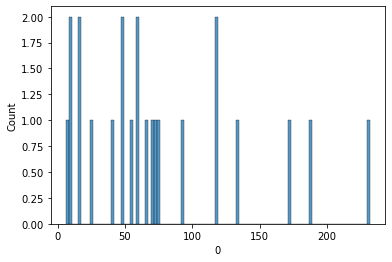

In [1651]:
sns.histplot(df_gene_tp_all_info.groupby(['nt_type_label','class_label'])[0].count().reset_index()[0], bins=100)

In [1549]:
df_gene_tp_all_info_mean

0         1         2         3       \
nt_type_label class_label                                              
GABA          CB GABA        -1.156890 -1.156890 -1.156890 -1.156890   
              CNU-HYa GABA   -1.208856 -1.208856 -1.208856 -1.208856   
              CNU-LGE GABA   -1.208142 -1.208142 -1.208142 -1.208142   
              CNU-MGE GABA   -1.283565 -1.283565 -1.283565 -1.283565   
              CTX-CGE GABA   -1.178919 -1.178919 -1.178919 -1.178919   
              CTX-MGE GABA   -1.236359 -1.236359 -1.236359 -1.236359   
              HY GABA        -1.236764 -1.236764 -1.236764 -1.236764   
              LSX GABA       -1.219065 -1.219065 -1.219065 -1.219065   
              MB GABA        -1.185796 -1.185796 -1.185796 -1.185796   
              MY GABA        -1.079498 -1.079498 -1.079498 -1.079498   
              OB-IMN GABA    -1.175259 -1.175259 -1.175259 -1.175259   
              P GABA         -1.230681 -1.230681 -1.230681 -1.230681   
Glut          Astro-Epen     -1.152851 -1.152851 -1.152851 -1.152851   
              CNU-HYa Glut   -1.256063 -1.256063 -1.256063 -1.256063   
              DG-IMN Glut    -1.340358 -1.340358 -1.340358 -1.340358   
              HY Glut        -1.170514 -1.170514 -1.170514 -1.170514   
              IT-ET Glut     -1.195247 -1.195247 -1.195247 -1.195247   
              MB Glut        -1.254043 -1.254043 -1.254043 -1.254043   
              MH-LH Glut     -1.142404 -1.142404 -1.142404 -1.142404   
              MY Glut        -1.269163 -1.269163 -1.269163 -1.269163   
              NP-CT-L6b Glut -1.324435 -1.324435 -1.324435 -1.324435   
              OB-CR Glut     -1.073164 -1.073164 -1.073164 -1.073164   
              P Glut         -1.306274 -1.306274 -1.306274 -1.306274   
              TH Glut        -1.215735 -1.215735 -1.215735 -1.215735   
NN            Astro-Epen     -1.218246 -1.218246 -1.218246 -1.218246   
              DG-IMN Glut    -1.065913 -1.065913 -1.065913 -1.065913   
              Immune         -1.047691 -1.047691 -1.047691 -1.047691   
              OB-IMN GABA    -1.039551 -1.039551 -1.039551 -1.039551   
              OPC-Oligo      -1.263415 -1.263415 -1.263415 -1.263415   
              Vascular       -1.146331 -1.146331 -1.146331 -1.146331   

                                4         5         6         7       \
nt_type_label class_label                                              
GABA          CB GABA        -1.156890 -1.156890 -1.156890 -1.156890   
              CNU-HYa GABA   -1.208856 -1.208856 -1.208856 -1.208856   
              CNU-LGE GABA   -1.208142 -1.208142 -1.208142 -1.208142   
              CNU-MGE GABA   -1.283565 -1.283565 -1.283565 -1.283565   
              CTX-CGE GABA   -1.178919 -1.178919 -1.178919 -1.178919   
              CTX-MGE GABA   -1.236359 -1.236359 -1.236359 -1.236359   
              HY GABA        -1.236764 -1.236764 -1.236764 -1.236764   
              LSX GABA       -1.219065 -1.219065 -1.219065 -1.219065   
              MB GABA        -1.185796 -1.185796 -1.185796 -1.185796   
              MY GABA        -1.079498 -1.079498 -1.079498 -1.079498   
              OB-IMN GABA    -1.175259 -1.175259 -1.175259 -1.175259   
              P GABA         -1.230681 -1.230681 -1.230681 -1.230681   
Glut          Astro-Epen     -1.152851 -1.152851 -1.152851 -1.152851   
              CNU-HYa Glut   -1.256063 -1.256063 -1.256063 -1.256063   
              DG-IMN Glut    -1.340358 -1.340358 -1.340358 -1.340358   
              HY Glut        -1.170514 -1.170514 -1.170514 -1.170514   
              IT-ET Glut     -1.195247 -1.195247 -1.195247 -1.195247   
              MB Glut        -1.254043 -1.254043 -1.254043 -1.254043   
              MH-LH Glut     -1.142404 -1.142404 -1.142404 -1.142404   
              MY Glut        -1.269163 -1.269163 -1.269163 -1.269163   
              NP-CT-L6b Glut -1.324435 -1.324435 -1.324435 -1.324435   
              OB-CR Glut     -1.073164 -1.073164 -1.073164 -1.073164   

In [1631]:
df_gene_tp_all_info_mean = df_gene_tp_all_info_mean.dropna(axis=1)

In [1632]:

all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [1633]:
all_bins_std.max()

11.992016792297363

In [1634]:
all_bins_std[all_bins_std >0.1]

300       0.119932
302       0.110387
303       0.128094
304       0.144298
305       0.109424
            ...   
246269    0.133194
246271    0.140215
246272    0.148109
246273    0.156640
246274    0.398694
Length: 142924, dtype: float32

In [1635]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=2)


proj_2d = umap_2d.fit_transform(features_sc)

In [1699]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

In [1636]:
all_bins_std.median()

0.10636676847934723

In [1637]:
#sns.histplot(all_bins_std)

In [1700]:
df_proj_2d= pd.DataFrame(proj_2d)

In [1639]:
df_gene_tp_all_info_mean

0         1         2         3       \
nt_type_label class_label                                              
GABA          CB GABA        -1.337916 -1.337916 -1.337916 -1.337916   
              CNU-HYa GABA   -1.231690 -1.231690 -1.231690 -1.231690   
              CNU-LGE GABA   -1.165112 -1.165112 -1.165112 -1.165112   
              CNU-MGE GABA   -1.230928 -1.230928 -1.230928 -1.230928   
              CTX-CGE GABA   -1.161817 -1.161817 -1.161817 -1.161817   
              CTX-MGE GABA   -1.136844 -1.136844 -1.136844 -1.136844   
              HY GABA        -1.199549 -1.199549 -1.199549 -1.199549   
              LSX GABA       -1.229095 -1.229095 -1.229095 -1.229095   
              MB GABA        -1.233492 -1.233492 -1.233492 -1.233492   
              MY GABA        -1.156199 -1.156199 -1.156199 -1.156199   
              OB-IMN GABA    -1.251157 -1.251157 -1.251157 -1.251157   
              P GABA         -1.341653 -1.341653 -1.341653 -1.341653   
Glut          CNU-HYa Glut   -1.230865 -1.230865 -1.230865 -1.230865   
              DG-IMN Glut    -1.341397 -1.341397 -1.341397 -1.341397   
              HY Glut        -1.188649 -1.188649 -1.188649 -1.188649   
              IT-ET Glut     -1.209937 -1.209937 -1.209937 -1.209937   
              MB Glut        -1.230926 -1.230926 -1.230926 -1.230926   
              MH-LH Glut     -1.143601 -1.143601 -1.143601 -1.143601   
              MY Glut        -1.270387 -1.270387 -1.270387 -1.270387   
              NP-CT-L6b Glut -1.242264 -1.242264 -1.242264 -1.242264   
              OB-CR Glut     -1.182054 -1.182054 -1.182054 -1.182054   
              P Glut         -1.293199 -1.293199 -1.293199 -1.293199   
              TH Glut        -1.214259 -1.214259 -1.214259 -1.214259   

                                4         5         6         7       \
nt_type_label class_label                                              
GABA          CB GABA        -1.337916 -1.337916 -1.337916 -1.337916   
              CNU-HYa GABA   -1.231690 -1.231690 -1.231690 -1.231690   
              CNU-LGE GABA   -1.165112 -1.165112 -1.165112 -1.165112   
              CNU-MGE GABA   -1.230928 -1.230928 -1.230928 -1.230928   
              CTX-CGE GABA   -1.161817 -1.161817 -1.161817 -1.161817   
              CTX-MGE GABA   -1.136844 -1.136844 -1.136844 -1.136844   
              HY GABA        -1.199549 -1.199549 -1.199549 -1.199549   
              LSX GABA       -1.229095 -1.229095 -1.229095 -1.229095   
              MB GABA        -1.233492 -1.233492 -1.233492 -1.233492   
              MY GABA        -1.156199 -1.156199 -1.156199 -1.156199   
              OB-IMN GABA    -1.251157 -1.251157 -1.251157 -1.251157   
              P GABA         -1.341653 -1.341653 -1.341653 -1.341653   
Glut          CNU-HYa Glut   -1.230865 -1.230865 -1.230865 -1.230865   
              DG-IMN Glut    -1.341397 -1.341397 -1.341397 -1.341397   
              HY Glut        -1.188649 -1.188649 -1.188649 -1.188649   
              IT-ET Glut     -1.209937 -1.209937 -1.209937 -1.209937   
              MB Glut        -1.230926 -1.230926 -1.230926 -1.230926   
              MH-LH Glut     -1.143601 -1.143601 -1.143601 -1.143601   
              MY Glut        -1.270387 -1.270387 -1.270387 -1.270387   
              NP-CT-L6b Glut -1.242264 -1.242264 -1.242264 -1.242264   
              OB-CR Glut     -1.182054 -1.182054 -1.182054 -1.182054   
              P Glut         -1.293199 -1.293199 -1.293199 -1.293199   
              TH Glut        -1.214259 -1.214259 -1.214259 -1.214259   

                                8         9       ...    246275    246276  \
nt_type_label class_label                         ...                       
GABA          CB GABA        -1.337916 -1.337916  ... -1.337916 -1.337916   
              CNU-HYa GABA   -1.231690 -1.231690  ... -1.228467 -1.228467   
              CNU-LGE GABA   -1.165112 -1.165112  ... -1.182083 -1.182083   
              CNU-MGE GABA   -1.230928 -1.230

In [1701]:
df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('nt_type_label')

df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('class_label')

df_proj_2d['class'] = [x.split()[1] if len(x.split())>1 else x.split()[0] for x in df_proj_2d['group']]

In [1643]:
df_proj_2d

0          1 classt           group class
0   3.607513  18.240021   GABA         CB GABA  GABA
1   1.833378  17.337542   GABA    CNU-HYa GABA  GABA
2   1.576391  16.523989   GABA    CNU-LGE GABA  GABA
3   3.610267  17.035368   GABA    CNU-MGE GABA  GABA
4   2.371571  16.210167   GABA    CTX-CGE GABA  GABA
5   2.197706  16.567213   GABA    CTX-MGE GABA  GABA
6   3.315794  15.772491   GABA         HY GABA  GABA
7   2.698593  17.107767   GABA        LSX GABA  GABA
8   2.918850  16.358381   GABA         MB GABA  GABA
9   4.510178  16.539568   GABA         MY GABA  GABA
10  2.345032  17.510702   GABA     OB-IMN GABA  GABA
11  3.712127  16.343485   GABA          P GABA  GABA
12  3.132051  16.789186   Glut    CNU-HYa Glut  Glut
13  2.872522  18.829308   Glut     DG-IMN Glut  Glut
14  4.226619  17.651022   Glut         HY Glut  Glut
15  4.516782  17.079723   Glut      IT-ET Glut  Glut
16  3.241223  17.626764   Glut         MB Glut  Glut
17  4.718359  18.006601   Glut      MH-LH Glut  Glut
18  3.474398  18.833681   Glut         MY Glut  Glut
19  2.919824  18.046955   Glut  NP-CT-L6b Glut  Glut
20  4.095032  18.916084   Glut      OB-CR Glut  Glut
21  3.853029  17.388744   Glut          P Glut  Glut
22  4.393174  18.436357   Glut         TH Glut  Glut

In [1644]:
df_proj_2d = df_proj_2d[~df_proj_2d['class'].isin(['Vascular', 'LQ', 'Immune'])]

In [1645]:
df_proj_2d = df_proj_2d[df_proj_2d['classt'].isin(['GABA', 'Glut'])]

In [1646]:
%matplotlib inline
import seaborn as sns
import random

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

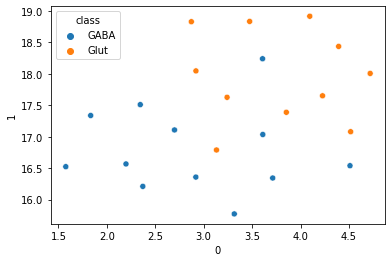

In [1647]:
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['class'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

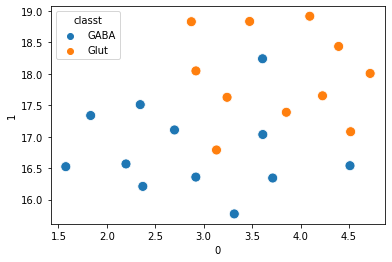

In [1650]:
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


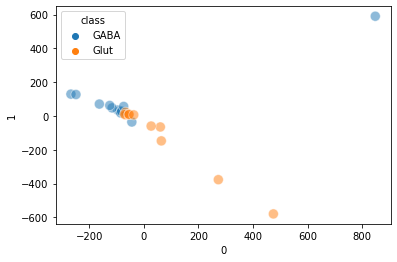

In [1710]:
ax = sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['class'], s=100, alpha=0.5
)
#ax.set_xlim([-800,800])
#ax.set_ylim([-200,200])

In [1692]:
df_proj_2d

0           1 classt           group class
0   848.432800  590.466675   GABA         CB GABA  GABA
1   -96.308807   35.806103   GABA    CNU-HYa GABA  GABA
2  -163.359802   70.770485   GABA    CNU-LGE GABA  GABA
3   -90.102585   31.578123   GABA    CNU-MGE GABA  GABA
4  -267.629578  129.560608   GABA    CTX-CGE GABA  GABA
5  -249.174820  127.236641   GABA    CTX-MGE GABA  GABA
6   -85.102547   18.151978   GABA         HY GABA  GABA
7  -116.457916   47.893913   GABA        LSX GABA  GABA
8   -81.805672   28.469219   GABA         MB GABA  GABA
9   -44.298702  -35.490047   GABA         MY GABA  GABA
10 -125.345825   62.443363   GABA     OB-IMN GABA  GABA
11  -74.141808   56.542343   GABA          P GABA  GABA
12  -67.328758   22.575972   Glut    CNU-HYa Glut  Glut
13  474.801483 -579.488464   Glut     DG-IMN Glut  Glut
14  -67.756760    6.988042   Glut         HY Glut  Glut
15  -71.073769   10.477115   Glut      IT-ET Glut  Glut
16  -55.594566    7.904104   Glut         MB Glut  Glut
17   63.871983 -147.262924   Glut      MH-LH Glut  Glut
18   60.369892  -64.907440   Glut         MY Glut  Glut
19  -54.210205    9.831166   Glut  NP-CT-L6b Glut  Glut
20  272.932129 -376.768311   Glut      OB-CR Glut  Glut
21  -37.269451    6.725904   Glut          P Glut  Glut
22   26.552879  -59.504002   Glut         TH Glut  Glut

<ipython-input-1684-8faceb48bbd4>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


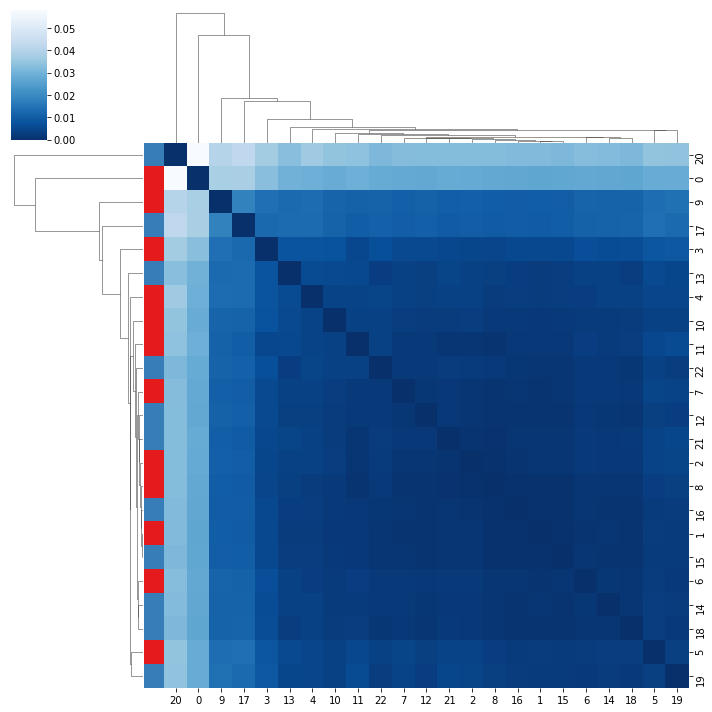

In [1684]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').map(lut)
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >1].index.tolist()]
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="Blues_r", row_colors=row_colors)


In [1683]:
all_bins_std[all_bins_mean >5]


8821       0.623917
8822       0.973360
8823       0.592111
8824       0.701797
8825       0.611994
8828       0.520311
18329      1.348174
29414     11.992017
37739      0.761488
38584      0.498509
54072      2.448498
84041      0.597800
94963      1.170679
127359     1.357054
127361     1.028926
130589     0.612019
139405     0.465314
141733     0.701526
145341     0.457303
146748     1.748274
152907     1.713984
152908     3.414302
158003     0.746377
163490     1.260065
177148     0.813257
190795     1.373958
208853     1.867451
217489     0.465607
225555     5.650160
231370     1.463528
235100     0.560057
dtype: float32

In [1671]:
all_bins_mean.median()

-0.00859885849058628

In [64]:
%matplotlib inline
import seaborn as sns
import random
bin_random = random.sample(range(2875012 ), 1000)

In [23]:
%matplotlib inline
import seaborn as sns

In [67]:
df_gene_tp_all_info_mean

0        1        2        3        \
classt        group         cell_type                                           
GABAergic     GABAergic     GABAergic          0.0      0.0      0.0      0.0   
Glutamatergic Glutamatergic Glutamatergic      0.0      0.0      0.0      0.0   
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0      0.0      0.0      0.0   

                                           4        5        6        7        \
classt        group         cell_type                                           
GABAergic     GABAergic     GABAergic          0.0      0.0      0.0      0.0   
Glutamatergic Glutamatergic Glutamatergic      0.0      0.0      0.0      0.0   
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0      0.0      0.0      0.0   

                                           8        9        ...  2462745  \
classt        group         cell_type                        ...            
GABAergic     GABAergic     GABAergic          0.0      0.0  ...      0.0   
Glutamatergic Glutamatergic Glutamatergic      0.0      0.0  ...      0.0   
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0      0.0  ...      0.0   

                                           2462746  2462747  2462748  2462749  \
classt        group         cell_type                                           
GABAergic     GABAergic     GABAergic          0.0      0.0      0.0      0.0   
Glutamatergic Glutamatergic Glutamatergic      0.0      0.0      0.0      0.0   
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0      0.0      0.0      0.0   

                                           2462750  2462751  2462752  2462753  \
classt        group         cell_type                                           
GABAergic     GABAergic     GABAergic          0.0      0.0      0.0      0.0   
Glutamatergic Glutamatergic Glutamatergic      0.0      0.0      0.0      0.0   
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0      0.0      0.0      0.0   

                                           2462754  
classt        group         cell_type               
GABAergic     GABAergic     GABAergic          0.0  
Glutamatergic Glutamatergic Glutamatergic      0.0  
Non-Neuronal  Non-Neuronal  Non-Neuronal       0.0  

[3 rows x 2462755 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


KeyboardInterrupt: 

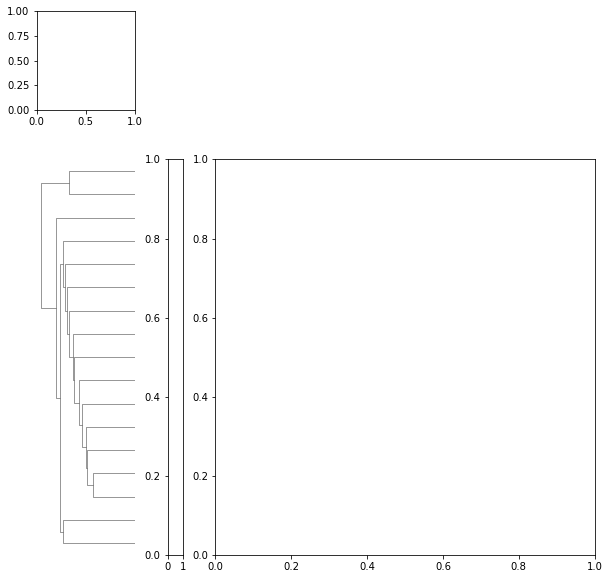

In [1394]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >= 0.4].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, z_score=1)


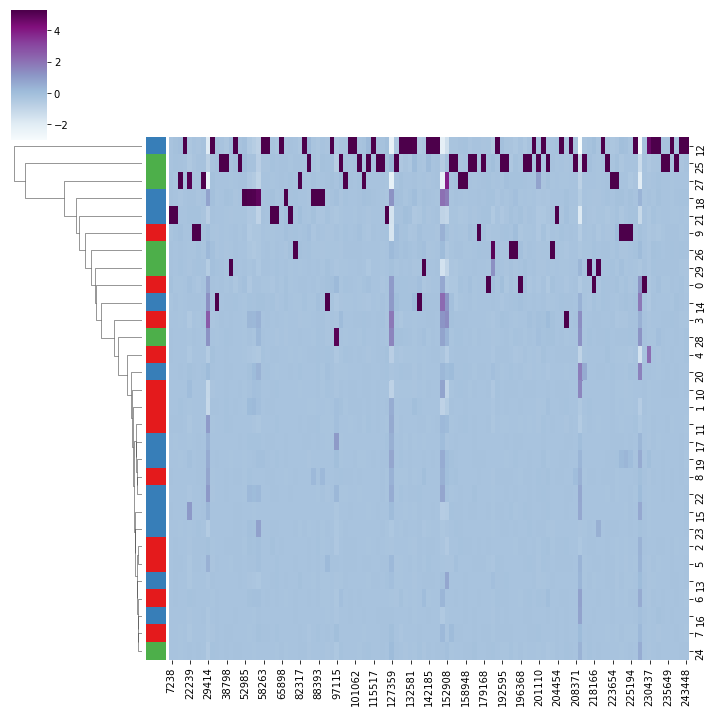

In [1576]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('nt_type_label').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 2].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors, z_score=1)


In [45]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [ ]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [59]:
all_bins_std[all_bins_std >= 0.3]

683       0.495169
706       0.605463
707       0.403575
748       0.446493
1064      0.456466
            ...   
244555    0.499223
244644    0.320725
245007    0.313347
245457    0.470738
246044    0.359147
Length: 1016, dtype: float32

In [62]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.2].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [63]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df_gene_tp_all_info_mean.index.get_level_values('classt'), labels={'color': 'classt'}
)


fig_2d.show()



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



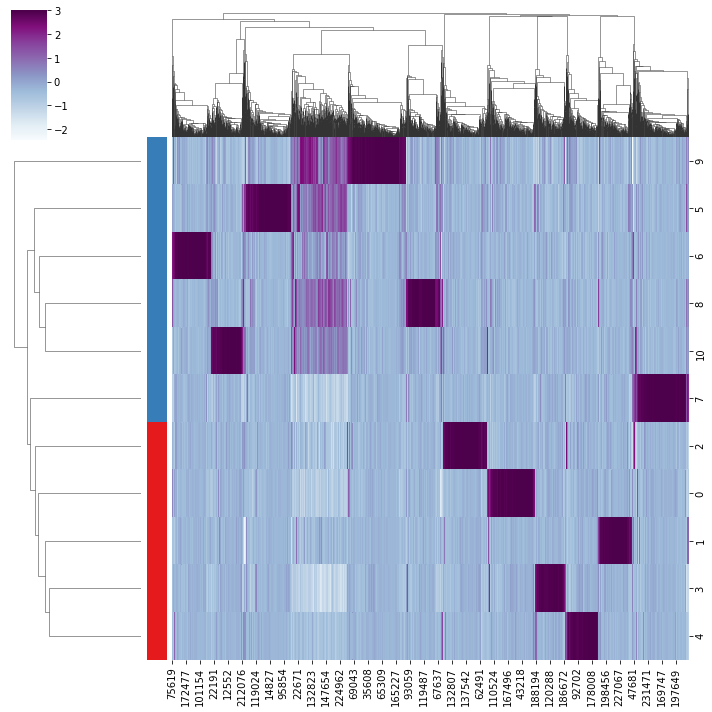

In [67]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.2].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, z_score=1)


In [27]:
df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 6].index.tolist()].reset_index(drop=True)

29414
0   174.477783
1   168.389084
2   182.006775
3   175.627823
4   177.750229
5   183.162354
6   184.160522
7   166.849304
8   182.848175
9   181.906143
10  186.417938

In [198]:
df_gene_tp_all_info_mean.max().max()

1.0

In [158]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [159]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [162]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [134]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [135]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)


In [140]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.cell_type, labels={'color': 'cell_type'}
)


fig_2d.show()

In [43]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [53]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [121]:
sns.color_palette("Paired", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928',
 '#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [124]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()



In [129]:
marker_list.group.head()

0    L6 CT
1    L6 CT
2    L6 CT
3    L6 CT
4    L6 CT
Name: group, dtype: object

In [127]:
fig_2d = px.scatter(
     x=df_proj_2d[0], y=df_proj_2d[1],
    color=df_proj_2d.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

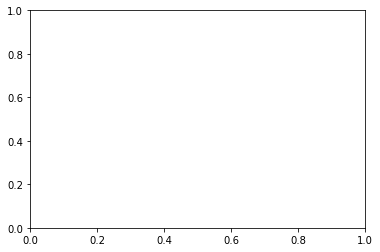

In [58]:
sns.scatterplot(proj_2d[:,0],proj_2d[:,1] , color=marker_list.group)

In [59]:
df_proj_2d= pd.DataFrame(proj_2d)

In [61]:
df_proj_2d['group'] = marker_list.group

In [62]:
df_proj_2d['cell_type'] = marker_list.cell_type

In [63]:
df_proj_2d['classt'] = marker_list.classt

In [72]:
df_proj_2d = df_proj_2d.sort_values(by=['classt', 'group', 'cell_type'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



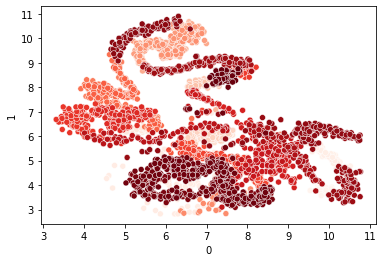

In [79]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette="Reds")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



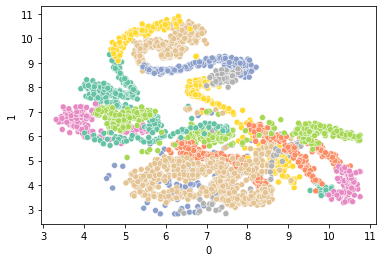

In [109]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.group, legend=False, palette=sns.color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0]))


In [111]:
color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0])

NameError: name 'color_palette' is not defined

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



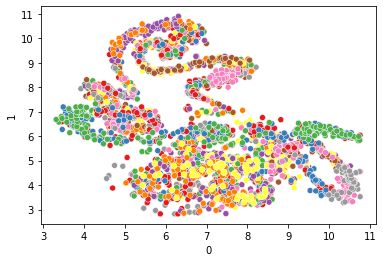

In [107]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette=sns.color_palette("Set1", df_proj_2d.cell_type.drop_duplicates().shape[0]))


In [98]:
df_proj_2d.group.drop_duplicates().shape[0]

24

In [83]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [84]:
sns.color_palette("Paired", 20)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

In [118]:
sns.color_palette("Set2",20).as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']

In [113]:
y = sns.color_palette("Set2",20)

In [116]:
y.as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']